In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN, KMeans
from shapely.geometry import MultiPoint, Point
from sklearn.metrics.pairwise import haversine_distances

## Datesets

1. SF Cabs dataset from CRAWDAD: https://ieee-dataport.org/open-access/crawdad-epflmobility
2. intersection counts: https://www.sfmta.com/reports/sfmta-traffic-count-data
3. map of traffic lights: https://data.sfgov.org/Transportation/Map-of-Traffic-Signals
4. info on cellular towers: https://www.city-data.com/towers/cell-San-Francisco-California.html
5. source for traffic light clustering: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [4]:
# parse sf cabs and store in dataframes
files = [f'../datasets/cabspottingdata/{file}' for file in os.listdir('../datasets/cabspottingdata/')]

start=0
end=100
cars = []
for f in tqdm(files):
    if not f.endswith('.txt'):
        continue 
    if f.endswith("_cabs.txt"):
        continue
    df = pd.read_csv(f, header=None, sep=' ')
    df['dt'] = pd.to_datetime(df[3],unit='s')

    cars.append(df)
#     ax.plot(df[0][start:end],df[1][start:end])#, s=1)
    


100%|████████████████████████████████████████████████| 538/538 [00:04<00:00, 130.35it/s]


In [65]:

# find earliest starting car
mints = np.inf
minc = None
for car in cars:
    if mints > car[3].iloc[-1]:
        minc = car
        mints = car[3].iloc[-1]


In [66]:
# calculate 1hr from earliest timestamp
lim_dt = pd.to_datetime(mints, unit='s')+timedelta(hours=1)

In [75]:
lim_dt2 = lim_dt + timedelta(hours=1)

In [76]:
lim_dt3 = lim_dt2 + timedelta(hours=1)

In [81]:
# filter all cars starting within the hour calculated above
# note, ts is ordered in reverse. i.e., last ts is beginnning
filtered_cars = []
for car in cars:
    if car['dt'].iloc[-1] > lim_dt3:
        continue
    tinydf = car[car['dt'] < lim_dt3][::-1]
    tinydf = tinydf.reset_index()
    tinydf.drop(columns=['index'])
    if not tinydf.empty:
        filtered_cars.append(tinydf)

In [77]:
# filter all cars starting within the hour calculated above
# note, ts is ordered in reverse. i.e., last ts is beginnning
filtered_cars = []
for car in cars:
    if car['dt'].iloc[-1] > lim_dt2:
        continue
    tinydf = car[car['dt'] < lim_dt2][::-1]
    tinydf = tinydf[tinydf['dt'] >= lim_dt]
    tinydf = tinydf.reset_index()
    tinydf.drop(columns=['index'])
    if not tinydf.empty:
        filtered_cars.append(tinydf)

In [79]:
# filter all cars starting within the hour calculated above
# note, ts is ordered in reverse. i.e., last ts is beginnning
filtered_cars = []
for car in cars:
    if car['dt'].iloc[-1] > lim_dt3:
        continue
    tinydf = car[car['dt'] < lim_dt3][::-1]
    tinydf = tinydf[tinydf['dt'] >= lim_dt2]
    tinydf = tinydf.reset_index()
    tinydf.drop(columns=['index'])
    if not tinydf.empty:
        filtered_cars.append(tinydf)

In [73]:
filtered_cars[2]

,index,0,1,2,3,dt
0,28066,37.79025,-122.41060,0,1211022031,2008-05-17 11:00:31
1,28065,37.78761,-122.40961,0,1211022088,2008-05-17 11:01:28
2,28064,37.78447,-122.40917,0,1211022148,2008-05-17 11:02:28
3,28063,37.78454,-122.40876,1,1211022171,2008-05-17 11:02:51
4,28062,37.78488,-122.41110,1,1211022226,2008-05-17 11:03:46
5,28061,37.78696,-122.41158,1,1211022286,2008-05-17 11:04:46
6,28060,37.79146,-122.41251,1,1211022346,2008-05-17 11:05:46
7,28059,37.79434,-122.41261,1,1211022407,2008-05-17 11:06:47
8,28058,37.79436,-122.41261,0,1211022408,2008-05-17 11:06:48
9,28057,37.79341,-122.40956,0,1211022468,2008-05-17 11:07:48


In [10]:
def conv_shape(x):
    tokens = x.split(' ')
    lat = float(tokens[1][1:])
    lon = float(tokens[2][:-1])
    return lat, lon 

In [12]:
# kmeans

kmeans = KMeans(n_clusters=12, random_state=0, n_init="auto").fit(coords)
# kmeans.labels_
# kmeans.predict([[0, 0], [12, 3]])
kmeans_centers = kmeans.cluster_centers_
cx = kmeans_centers[:,0]
cy = kmeans_centers[:,1]
kmeans_centers_radians = np.radians(kmeans_centers)
kmeans_centers_radians

array([[-2.13621399,  0.6592231 ],
       [-2.13773105,  0.65927328],
       [-2.13710002,  0.659386  ],
       [-2.13660349,  0.65894802],
       [-2.13800538,  0.65873223],
       [-2.13667539,  0.65969546],
       [-2.13698358,  0.65835557],
       [-2.13630053,  0.65959244],
       [-2.13620961,  0.65856439],
       [-2.13666377,  0.65936944],
       [-2.13756118,  0.65849099],
       [-2.13719296,  0.65897978]])

In [11]:
# cluster the traffic lights and obtain centroids
df = pd.read_csv('../datasets/Traffic_Signals_20231211.csv')
df['x'],df['y'] = zip(*df['shape'].apply(conv_shape))
coords = df[['x','y']].values


kms_per_radian = 6371.0088
# controls the number of clusters
eps = 0.5 / kms_per_radian
ms=1

db = DBSCAN(eps=eps, min_samples=ms, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

print('Number of clusters: {}'.format(num_clusters))

def get_centermost_point(cluster):
    return (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

centroids = clusters.map(get_centermost_point)
cx,cy = zip(*centroids)
centroids_np = np.vstack((cx,cy))
# np.save('../datasets/12-nodes.npy',centroids_np) 

Number of clusters: 12


-122.39604588073395 37.770701211009175
-122.48296668965517 37.77357659770115
-122.44681177245509 37.78003485628742
-122.4183623875969 37.75494055813954
-122.49868463414634 37.742576658536585
-122.42248182758621 37.79776544827586
-122.44013993457943 37.72099534579439
-122.4010043206751 37.791863101265825
-122.39579507777778 37.73295993333333
-122.4218164672489 37.77908612663755
-122.47323404 37.72875429333333
-122.45213685915493 37.75676007042254


[]

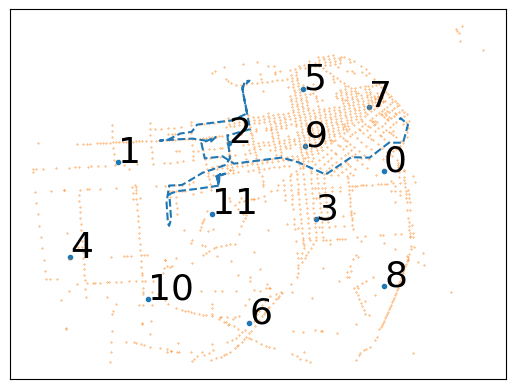

In [49]:
# plot for visualizing edge nodeks and route
fig, ax = plt.subplots()
for car in filtered_cars[7:8]:
# for car in filtered_cars[:50]:

    ax.plot(car[1],car[0], linestyle='dashed') 
ax.scatter(cx, cy, marker='.')
ax.scatter(df['x'],df['y'],s=0.1)
for i,x in enumerate(cx):
    y = cy[i]
    ax.annotate(str(i),(x,y), fontsize=26)
    print(x,y)
    
ax.set_yticks([])
ax.set_xticks([])
# ax.set_xlim(-122.43868463414635, -122.39079507777860)
# ax.set_ylim(37.72099534579439, 37.80776544827586)
# ax.set_ylim()
# fig.savefig('../paper/figs/sf_clustering.pdf')

In [362]:
# get radian centroids for haversine distances
x,y = zip(*centroids)
centroids_np = np.radians(np.vstack((x,y)).T)
centroids_np

array([[-2.13678731,  0.6591912 ],
       [-2.1358273 ,  0.6585291 ],
       [-2.1366605 ,  0.65822749],
       [-2.1357841 ,  0.66001889],
       [-2.13687799,  0.65888457],
       [-2.13803152,  0.65832397],
       [-2.13564369,  0.65991847],
       [-2.13604651,  0.65818396],
       [-2.13656051,  0.65866984],
       [-2.1364833 ,  0.65829823],
       [-2.13662317,  0.65849608],
       [-2.13819292,  0.65938277]])

In [82]:
# assigns proximal edge node to every line in the route

considered_nodes = [0,2,3,5,7,8,9]
# centroids_radians = centroids_np
centroids_radians = kmeans_centers_radians
centroids_radians = centroids_radians[considered_nodes]

for i,car in enumerate(filtered_cars):
    route = np.radians(car[[1,0]].values)
    dists = haversine_distances(centroids_radians,route)               
    car['node'] = dists.T.argmin(axis=1)
    car['ts'] = car[3]-car[3].at[0]
    car.to_csv(f'../datasets/routes-fh3-7hn/route{i}.csv', index=False)


In [60]:
filtered_cars[2]

,index,0,1,2,3,dt,node,ts
0,18746,37.77529,-122.40967,1,1211018422,2008-05-17 10:00:22,6,0
1,18745,37.77758,-122.40450,1,1211018483,2008-05-17 10:01:23,4,61
2,18744,37.77648,-122.40521,1,1211018533,2008-05-17 10:02:13,4,111
3,18743,37.77633,-122.40542,0,1211018535,2008-05-17 10:02:15,4,113
4,18742,37.77384,-122.40854,0,1211018595,2008-05-17 10:03:15,4,173
5,18741,37.77364,-122.41151,0,1211018655,2008-05-17 10:04:15,6,233
6,18740,37.77415,-122.41426,0,1211018715,2008-05-17 10:05:15,6,293
7,18739,37.77316,-122.41541,0,1211018775,2008-05-17 10:06:15,6,353
8,18738,37.76905,-122.41566,0,1211018835,2008-05-17 10:07:15,2,413
9,18737,37.76523,-122.41753,0,1211018895,2008-05-17 10:08:15,2,473


In [50]:

for i in range(12):
    df = pd.read_csv(f'../loadgen/sfcab-12-site-load/sfcabs_site{i}.csv')
    df['dur'] = df['end']-df['start']

    #scaling, because drone data is only 1m38s (so largest duration can be filtered to 2600/20 )
    df['dur'] = df['dur']/20
    df['start'] = df['start']/20
    df['end'] = df['end']/20

    edf = df.sort_values('dur').reset_index(drop=True)
    fdf = edf[edf['dur']!=0.0] #remove 0 values. not useful.
    gdf = fdf[fdf['dur']<130]
    hdf = gdf.sort_values('start').reset_index(drop=True)
    hdf.to_csv(f'../loadgen/sfcabs_processed_site{i}.csv', index=False)


In [53]:
hdf.sort_values('end').reset_index(drop=True)

,cabid,start,end,dur
0,305.0,0.000,2.800,2.800
1,169.0,0.000,5.105,5.105
2,178.0,0.000,6.005,6.005
3,247.0,0.000,6.055,6.055
4,262.0,3.350,6.105,2.755
...,...,...,...,...
119,100.0,167.255,175.205,7.950
120,326.0,150.155,175.255,25.100
121,147.0,164.255,176.505,12.250
122,23.0,167.655,176.555,8.900


In [62]:
hdf[hdf['cabid']==286.0]

,cabid,start,end,dur


In [51]:
all_events = np.hstack((hdf['start'].values, hdf['end'].values))
np.unique(np.sort(all_events))

array([  0.   ,   2.8  ,   3.05 ,   3.35 ,   5.105,   6.005,   6.055,
         6.105,   6.205,   6.605,   8.105,   8.355,   8.605,   8.955,
         9.005,   9.555,  10.105,  10.805,  11.555,  11.905,  12.205,
        12.705,  12.755,  14.805,  15.1  ,  15.25 ,  15.85 ,  15.9  ,
        16.   ,  16.5  ,  17.6  ,  17.65 ,  18.25 ,  18.6  ,  19.85 ,
        21.   ,  21.05 ,  21.2  ,  22.9  ,  23.2  ,  23.6  ,  23.75 ,
        24.05 ,  24.1  ,  24.7  ,  25.1  ,  25.55 ,  26.15 ,  26.3  ,
        26.8  ,  27.45 ,  27.65 ,  28.05 ,  28.55 ,  28.9  ,  29.3  ,
        29.8  ,  30.   ,  31.   ,  31.1  ,  31.45 ,  32.3  ,  32.35 ,
        32.65 ,  35.25 ,  35.35 ,  36.35 ,  36.65 ,  38.7  ,  38.8  ,
        39.05 ,  39.25 ,  39.45 ,  39.55 ,  40.   ,  41.2  ,  41.85 ,
        44.2  ,  44.8  ,  45.2  ,  45.3  ,  45.45 ,  46.95 ,  50.45 ,
        50.8  ,  51.05 ,  51.25 ,  51.45 ,  51.95 ,  52.15 ,  53.25 ,
        53.7  ,  54.4  ,  56.25 ,  57.15 ,  57.2  ,  58.35 ,  59.7  ,
        60.   ,  63.

(0.0, 2600.0)

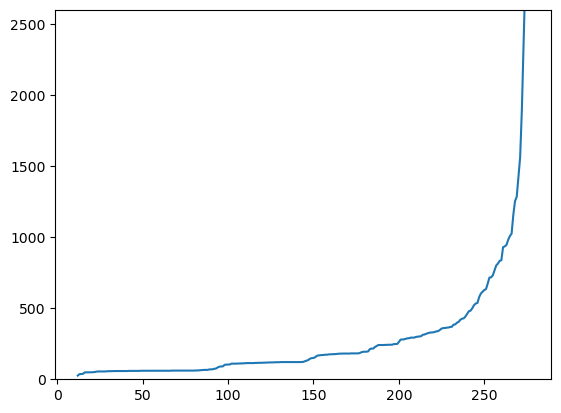

In [25]:
fig,ax = plt.subplots()
tdf['dur'].plot(ax=ax)
ax.set_ylim(0,2600)


In [2]:
import os
import pandas as pd
lam = []
path='../loadgen/cellular-12n/'
files = os.listdir(path)
for file in files:
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(f'{path}/{file}')
    df['dur'] = df['end']-df['start']
    lam.append(len(df)/3600)
    print(file, df['dur'].max(), len(df)/3600)

sfcabs_site8.csv 3546.0999999978703 0.07055555555555555
sfcabs_site9.csv 2281.0999999979254 0.02388888888888889
sfcabs_site10.csv 3590.0999999978303 0.11
sfcabs_site2.csv 2328.099999998978 0.08888888888888889
sfcabs_site3.csv 3127.0999999978494 0.07805555555555556
sfcabs_site11.csv 3111.099999998266 0.049444444444444444
sfcabs_site1.csv 2538.0999999977107 0.13472222222222222
sfcabs_site0.csv 964.0999999991232 0.005
sfcabs_site4.csv 1970.0999999993037 0.016944444444444446
sfcabs_site5.csv 2966.0999999978003 0.06444444444444444
sfcabs_site7.csv 2658.099999997798 0.058055555555555555
sfcabs_site6.csv 1461.9999999986703 0.030833333333333334


In [13]:
import numpy as np
np.sort(lam)

array([0.005     , 0.01694444, 0.02388889, 0.03083333, 0.04944444,
       0.05805556, 0.06444444, 0.07055556, 0.07805556, 0.08888889,
       0.11      , 0.13472222])

<Axes: >

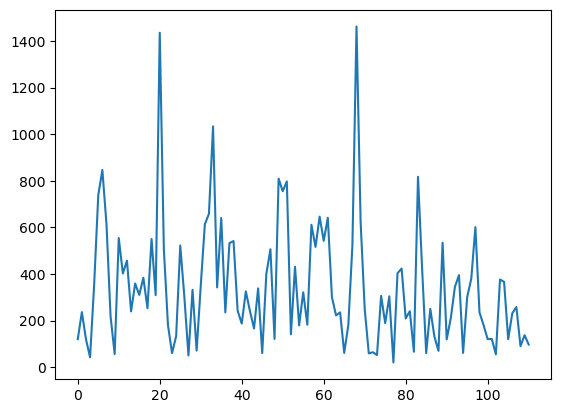

In [3]:
df['dur'].plot()